###  CORTX Metrics Compare Open Source Projects 

This jupyter notebook does some analysis and graphing comparing various open source object storage systems

In [34]:
%%capture
%cd /home/johnbent/cortx/metrics
import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cortx_community as cc
import cortx_graphing as cg
import datetime
from github import Github

In [35]:
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams.update({'font.size': 22})
plt.rcParams['lines.markersize'] = 10

orgs = cc.projects
star_data={}
fork_data={}

In [36]:
def get_all_repos(gh,Verbose=False):
    repos={}
    for project,org in orgs.items():
        org_name    = org[0]
        repo_prefix = org[1]
        repos[project] = cc.get_repos(gh=gh,org_name=org_name,prefix=repo_prefix)
    if Verbose:
        for p,r in repos.items():
            print(p, [k.name for k in r])
    return repos

In [37]:
# a function which returns a list of days from 0 to last day on which a repo got a star/fork
# and a list of the star/fork counts on each of those days
# also fills in the missing days on which no stars/forks were added
def get_stars_or_forks(gh,repos,what,org_name,Verbose=False):
    dates = {}
    # get all the data
    for r in repos:
        if Verbose:
            print("Fetching %s for %s : %s" % (what, org_name,r.name))
        if what is 'stars':
            items = r.get_stargazers_with_dates()
        else:
            items = r.get_forks()
        for sg in items:
            cc.avoid_rate_limiting(gh)
            if what is 'stars':
                d = sg.starred_at
            else:
                d = sg.created_at
            if d not in dates:
                dates[d]=0
            dates[d] += 1
    # convert all the data
    first_day = None
    last_day = None
    count = 0
    counts={}
    for d in sorted(dates):
        if first_day is None:
            first_day = d
        day = (d - first_day).days
        count += dates[d]
        counts[day] = count
        last_day = day
    days = list(range(last_day+1))
    stars = []
    last_stars=0
    for i in range(last_day+1):
        try:
            last_stars = counts[i]
        except KeyError:
            pass
        stars.append(last_stars)
    return(days,stars)

def get_stars(gh,repos,org_name,Verbose=False):
    return get_stars_or_forks(gh,repos,'stars',org_name,Verbose)

def get_forks(gh,repos,org_name,Verbose=False):
    return get_stars_or_forks(gh,repos, 'forks',org_name,Verbose)

In [38]:
def print_last_day(org,items,days,what,last_day):
    print("%5s has %6d %s as of day %4d and had %4d %s on day %d" % 
          (org,items[-1],what,days[-1],items[last_day],what,last_day))

def get_dataframe(data):
    def add_items_to_df(df,name,items):
        df1=pd.DataFrame(data={name : items})
        return pd.concat([df, df1], axis=1) 
    
    largest=0
    name_of_largest = None
    for k,v in data.items():
        if len(v[1]) > largest:
            largest = len(v[1])
            name_of_largest = k
    df=pd.DataFrame(index=data[name_of_largest][0],data={ name_of_largest : data[name_of_largest][1] })
    for k,v in data.items():
        if k is not name_of_largest:
            df=add_items_to_df(df,k,v[1])
    return df

def get_dataframe2(data):
    def add_items_to_df(df,name,items):
        df1=pd.DataFrame(data={name : items})
        return pd.concat([df, df1], axis=1) 
    
    # collect all indices from all data sets
    tmp_indices=set()
    for k,v in data.items():
        tmp_indices |= set(v[0])
    indices=list(sorted(tmp_indices))
    
    # collect all data from all data set using the union of the indices
    all_data={}
    for k,v in data.items():
        data=[]
        for i in indices:
            found = False
            for j in range(len(v[1])):
                if v[0][j] == i:
                    data.append(v[1][j])
                    found = True
            if not found:
                data.append(None)
        all_data[k]=data
    df=pd.DataFrame(index=indices,data=all_data)
    return df.fillna(method='ffill')

def make_graph(df,data,end_day,title,what):
    def get_max_y(data):
        max_y=0
        for k,v in data.items():
            try:
                this_max = v[1][end_day]
            except IndexError:
                this_max = v[1][-1]
            max_y = max(max_y,this_max)
        return max_y * 1.1 # increase it by 10% to add some margin at top of graph

    if end_day:
        max_y=get_max_y(data)
    else:
        max_y=None
    ax=df.plot(xlim=(None,end_day),ylim=(0,max_y),title="%s %s Data" % (title,what))
    ax.set_ylabel('%s Count' % what)
    ax.set_xlabel('Day')
    plt.show()

In [39]:
Verbose=False
gh = Github(os.environ.get('GH_OATH'))
repos = get_all_repos(gh,Verbose=Verbose)

In [42]:
# fetch fork data
Verbose=True
for p in orgs.keys():
    fork_data[p]=get_forks(gh,repos[p],p,Verbose=Verbose)
    star_data[p]=get_stars(gh,repos[p],p,Verbose=Verbose)

Fetching forks for MinIO : minio
Fetching forks for MinIO : mc
Fetching forks for MinIO : cli
Fetching forks for MinIO : minio-go
Fetching forks for MinIO : minio-java
Fetching forks for MinIO : minio-js
Fetching forks for MinIO : minio-py
Fetching forks for MinIO : minio-dotnet
Fetching forks for MinIO : attic
Fetching forks for MinIO : docs
Fetching forks for MinIO : concert
Fetching forks for MinIO : minio-js-store-app
Fetching forks for MinIO : minio-go-media-player
Fetching forks for MinIO : minio-java-rest-example
Fetching forks for MinIO : android-photo-app
Fetching forks for MinIO : swift-photo-app
Fetching forks for MinIO : ror-resumeuploader-app
Fetching forks for MinIO : doctor
Fetching forks for MinIO : awesome-minio
Fetching forks for MinIO : blake2b-simd
Fetching forks for MinIO : asm2plan9s
Fetching forks for MinIO : sha256-simd
Fetching forks for MinIO : dsync
Fetching forks for MinIO : minfs
Fetching forks for MinIO : minio-ruby
Fetching forks for MinIO : xfile
Fetchin

Fetching stars for CORTX : cortx-motr
Fetching stars for CORTX : cortx-images
Fetching forks for Ceph : ceph
Fetching forks for Ceph : ceph-qa-chef
Fetching forks for Ceph : ceph-client
Fetching forks for Ceph : qemu-kvm
Fetching forks for Ceph : teuthology
Fetching forks for Ceph : s3-tests
Fetching forks for Ceph : ceph-qa-suite
Fetching forks for Ceph : handle_core
Fetching forks for Ceph : autobuild-ceph
Fetching forks for Ceph : phprados
Fetching forks for Ceph : collectd
Fetching forks for Ceph : collectd-4.10.1
Fetching forks for Ceph : mod_fastcgi
Fetching forks for Ceph : apache2
Fetching forks for Ceph : ceph-cookbook
Fetching forks for Ceph : ceph-client-standalone
Fetching forks for Ceph : ceph-build
Fetching forks for Ceph : ceph-openstack-tools
Fetching forks for Ceph : ceph-autotests
Fetching forks for Ceph : barclamp-ceph
Fetching forks for Ceph : swift
Fetching forks for Ceph : sphinx-ditaa
Fetching forks for Ceph : asphyxiate
Fetching forks for Ceph : ceph-tools
Fetch

Fetching stars for Ceph : qemu-iotests
Fetching stars for Ceph : calamari
Fetching stars for Ceph : Diamond
Fetching stars for Ceph : pushy
Fetching stars for Ceph : radosgw-agent
Fetching stars for Ceph : ceph-nagios-plugins
Fetching stars for Ceph : rados-java
Fetching stars for Ceph : tgt
Fetching stars for Ceph : remoto
Fetching stars for Ceph : calamari-clients
Fetching stars for Ceph : paddles
Fetching stars for Ceph : pulpito
Fetching stars for Ceph : ice-setup
Fetching stars for Ceph : radosgw-apache
Fetching stars for Ceph : mongoose
Fetching stars for Ceph : puppet-ceph
Fetching stars for Ceph : civetweb
Fetching stars for Ceph : graphite-web
Fetching stars for Ceph : ceph-ansible
Fetching stars for Ceph : ceph-kmod-rpm
Fetching stars for Ceph : jerasure
Fetching stars for Ceph : gf-complete
Fetching stars for Ceph : cephfs-hadoop
Fetching stars for Ceph : rocksdb
Fetching stars for Ceph : zeromq4-x
Fetching stars for Ceph : empty
Fetching stars for Ceph : jenkins-slave-chef


Fetching stars for DAOS : go-spdk
Fetching stars for DAOS : iof
Fetching stars for DAOS : openpa
Fetching stars for DAOS : libfabric
Fetching stars for DAOS : mercury
Fetching stars for DAOS : mpich
Fetching stars for DAOS : ishell
Fetching stars for DAOS : pipeline-lib
Fetching stars for DAOS : go-ipmctl
Fetching stars for DAOS : scons_local
Fetching stars for DAOS : code_review
Fetching stars for DAOS : ompi
Fetching stars for DAOS : pmix
Fetching stars for DAOS : argobots
Fetching stars for DAOS : pmdk
Fetching stars for DAOS : fuse
Fetching stars for DAOS : protobuf-c
Fetching stars for DAOS : spdk
Fetching stars for DAOS : fio
Fetching stars for DAOS : dpdk
Fetching stars for DAOS : isa-l
Fetching stars for DAOS : scons
Fetching stars for DAOS : meson
Fetching stars for DAOS : python-pathlib
Fetching stars for DAOS : pdsh
Fetching stars for DAOS : automake
Fetching stars for DAOS : daos-stack.github.io
Fetching stars for DAOS : libtool
Fetching stars for DAOS : slurm
Fetching star

The next four graphs compare CORTX to a variety of other open source object storage systems.  All graphs normalize the data for each project to each's respective "day zero". Stars are more of a reflection of popularity and marketing whereas forks are a reflection of a much deeper interest in the software.

In [46]:
import pickle
projects_data = { 'forks' : fork_data, 'stars' : star_data}
with open('pickles/compare_projects.pickle', 'wb') as f:
    pickle.dump(projects_data,f)

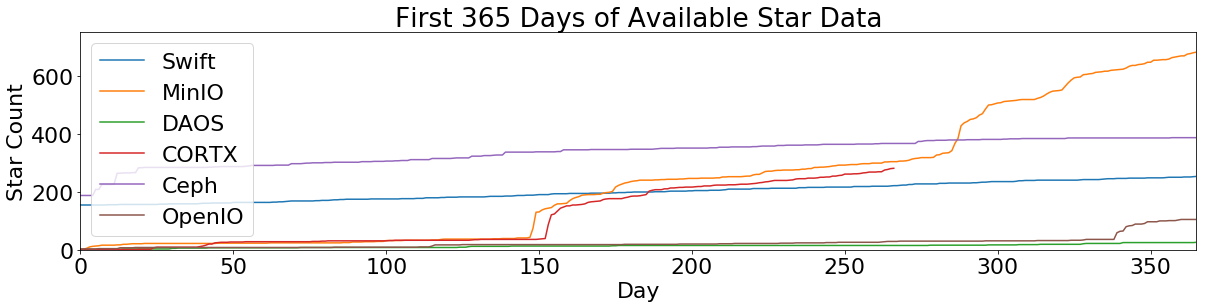

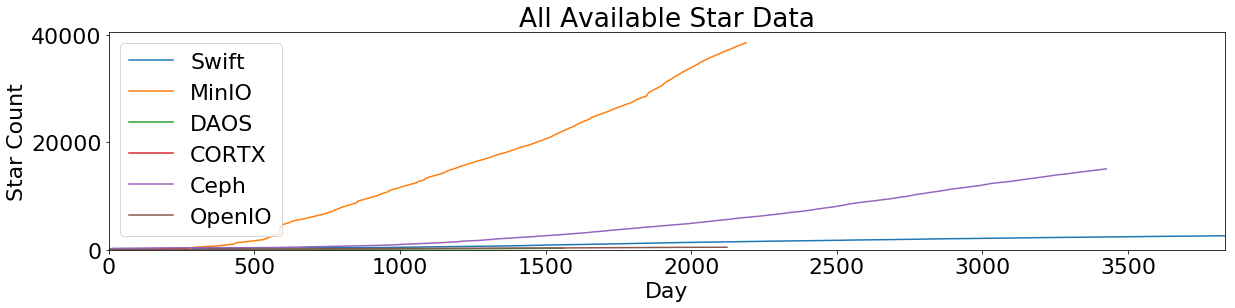

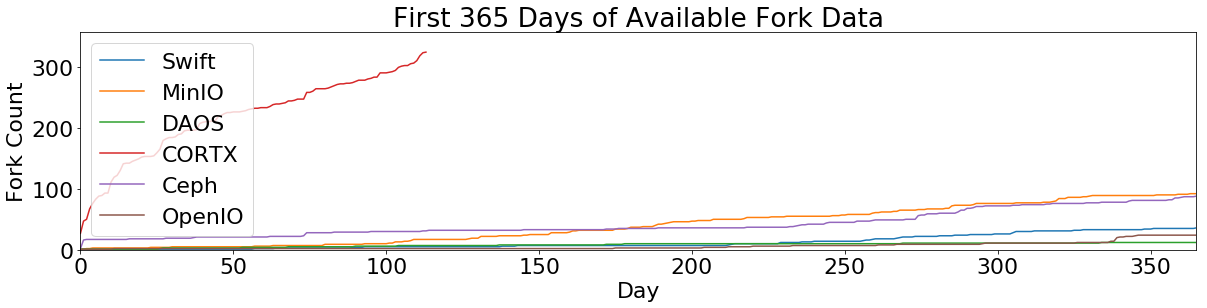

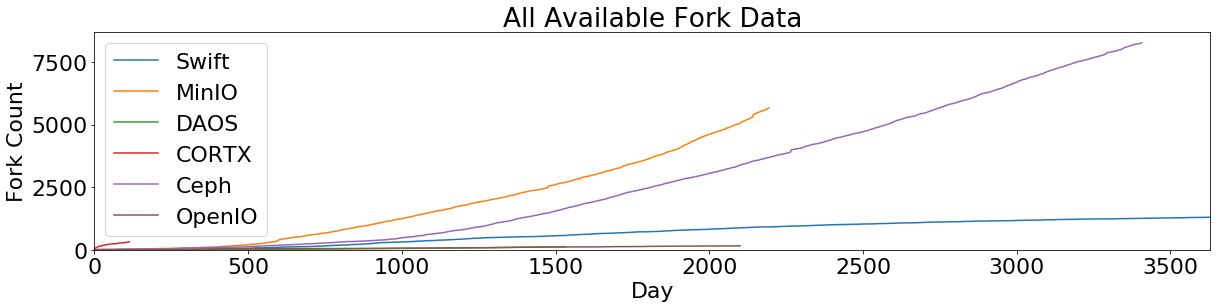

In [44]:
# star graphs
df=get_dataframe(star_data)
make_graph(df=df,data=star_data,end_day=365,title="First 365 Days of Available",what='Star')
make_graph(df=df,data=star_data,end_day=None,title="All Available",what='Star')

# fork graphs
df=get_dataframe(fork_data)
make_graph(df=df,data=fork_data,end_day=365,title="First 365 Days of Available",what='Fork')
make_graph(df=df,data=fork_data,end_day=None,title="All Available",what='Fork')

The graphs below compare each project using absolute dates on the horizontal axis and every scraped metric on the vertical.

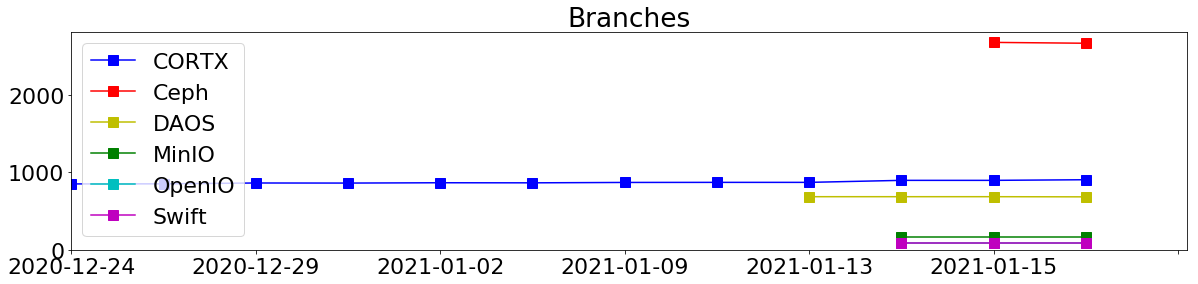

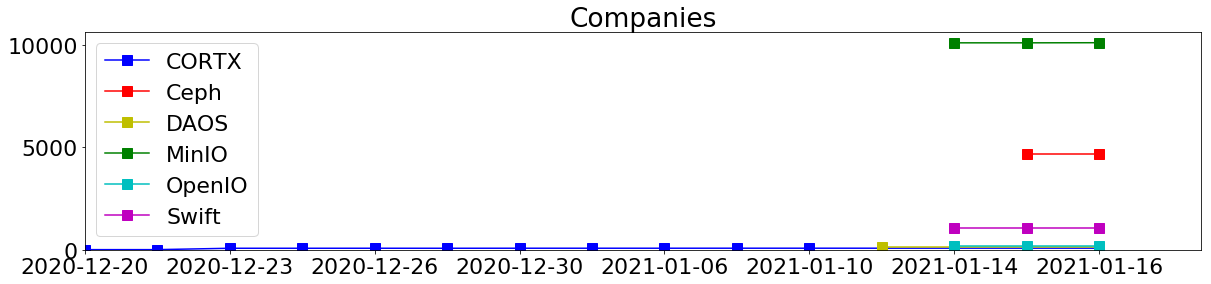

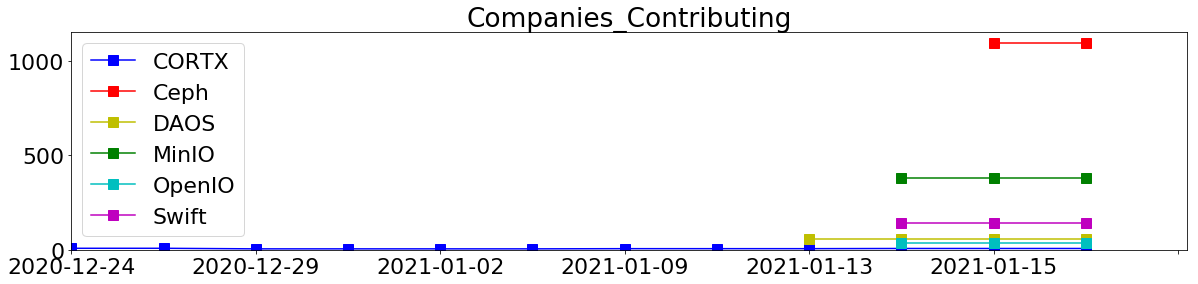

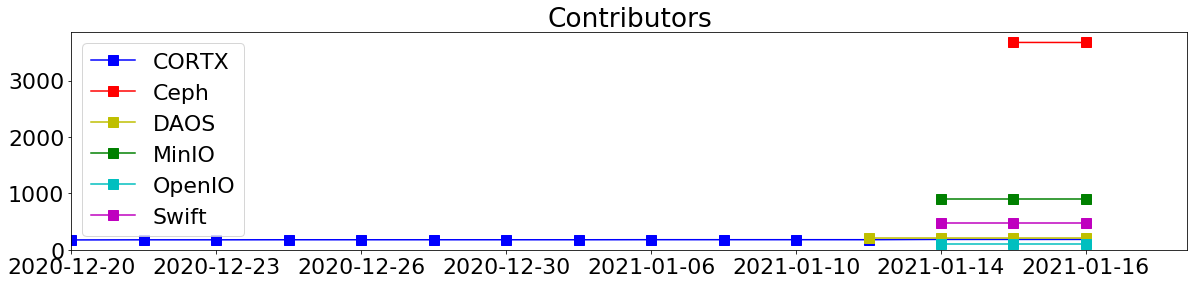

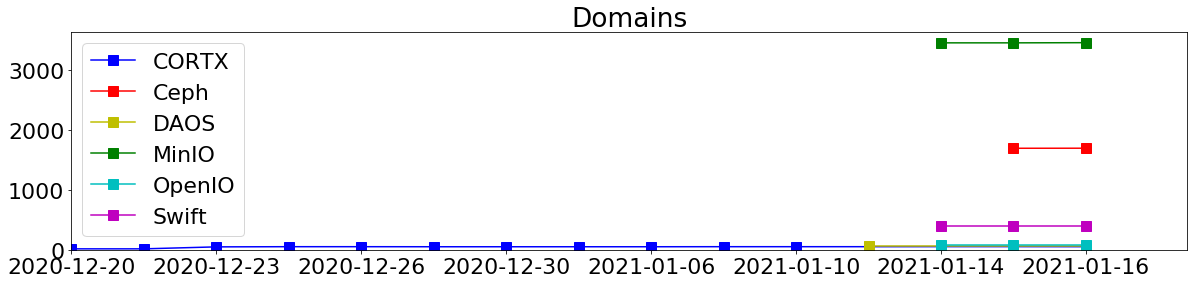

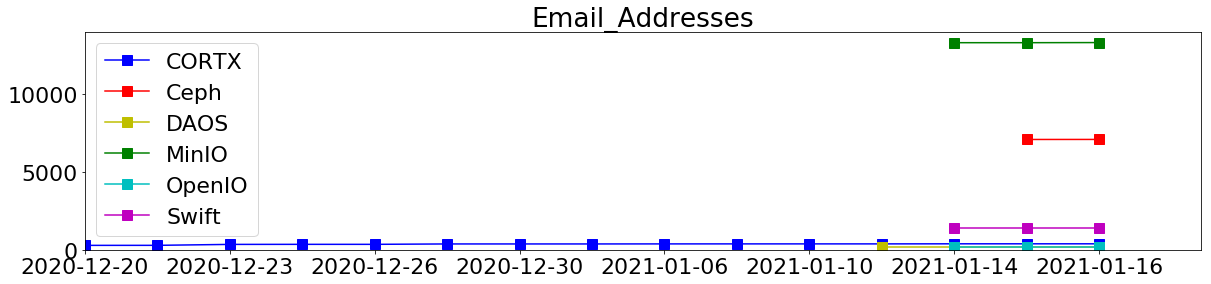

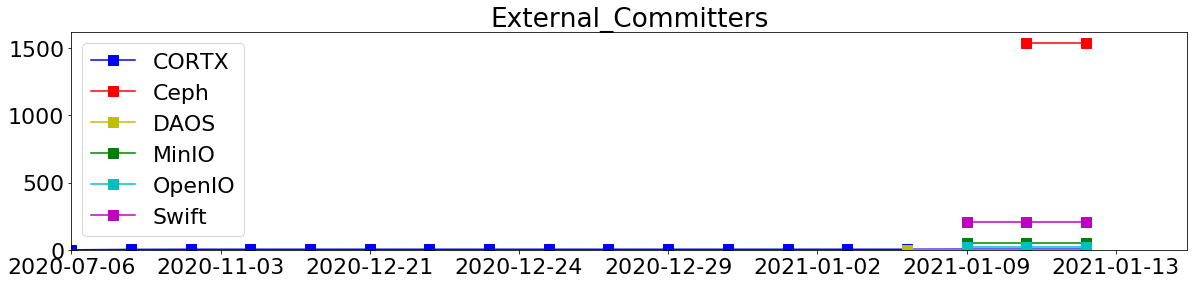

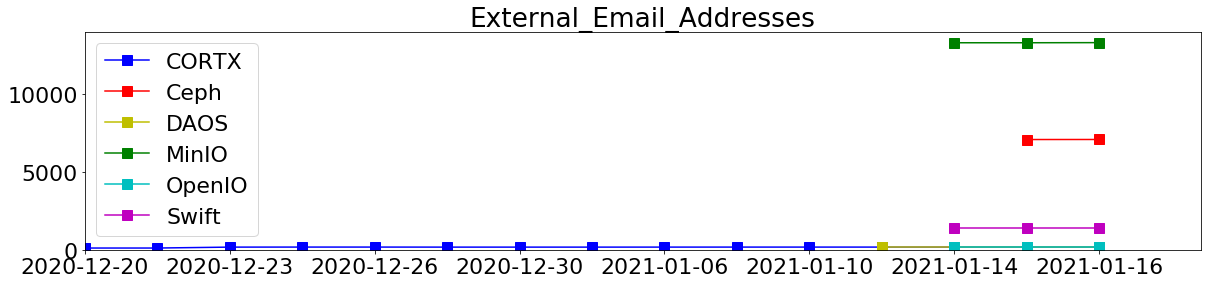

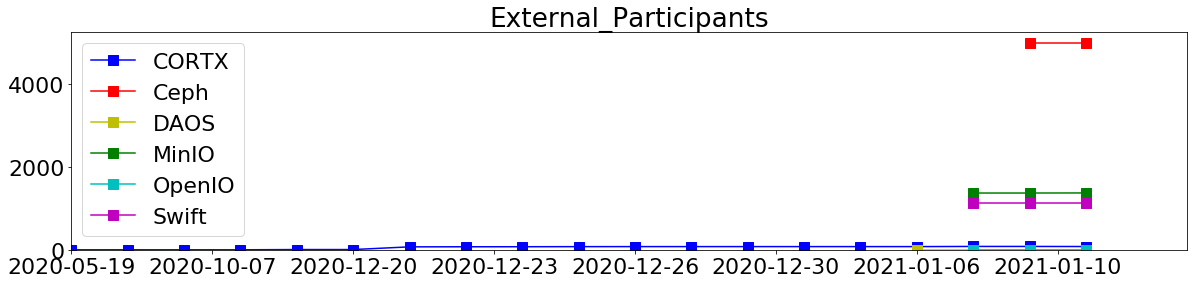

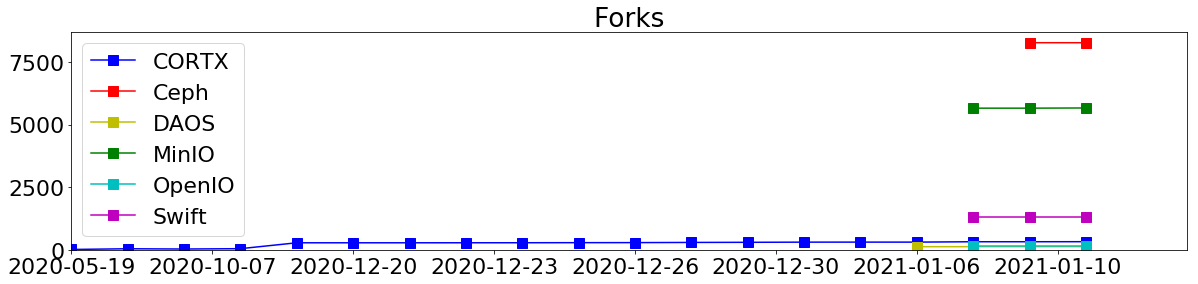

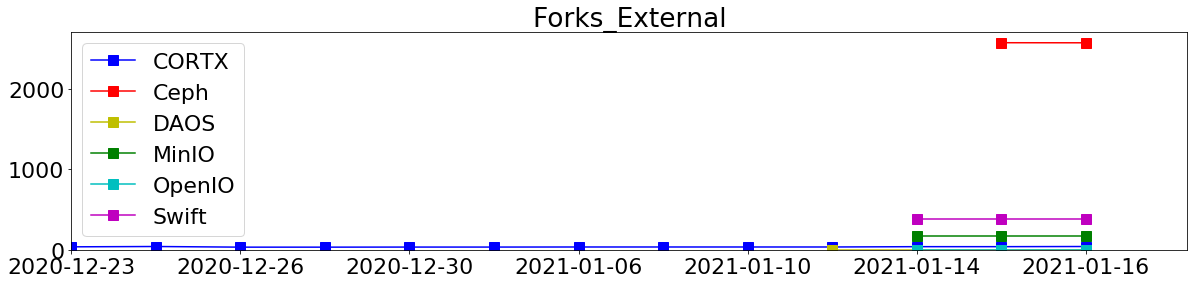

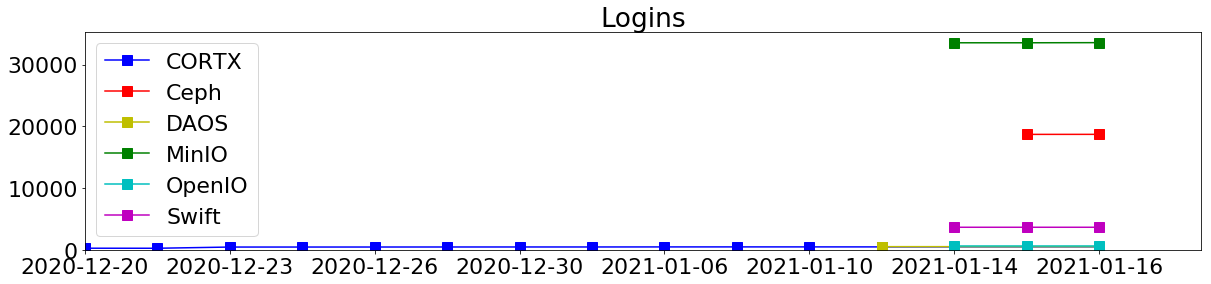

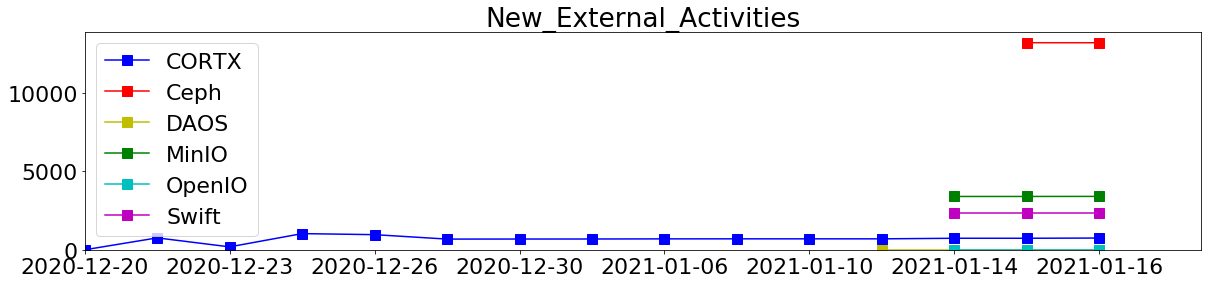

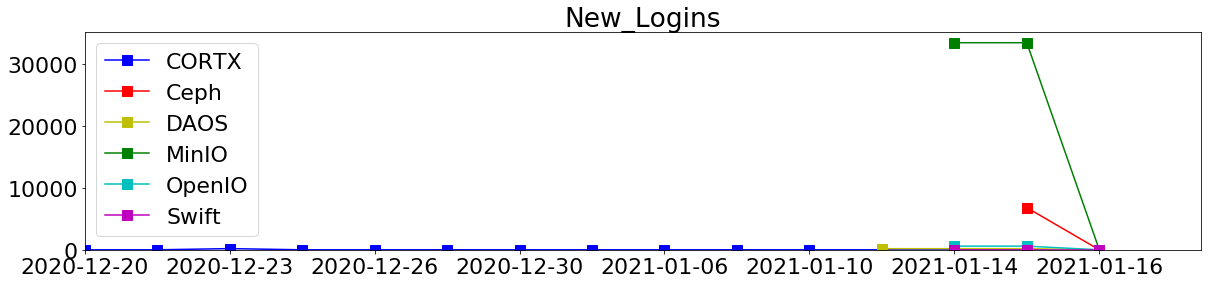

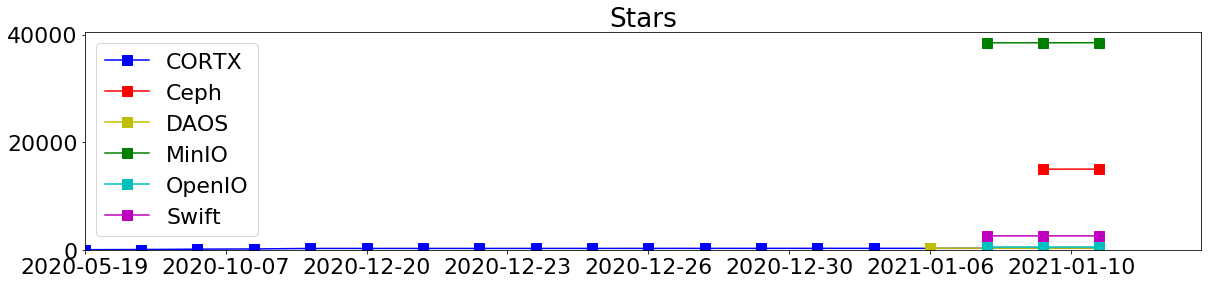

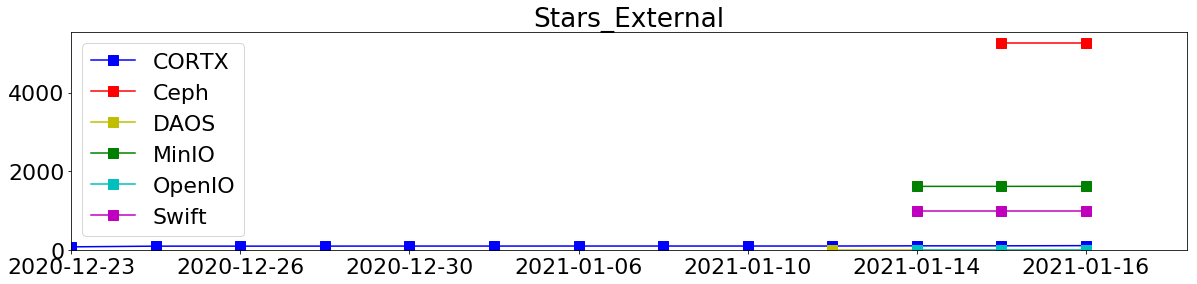

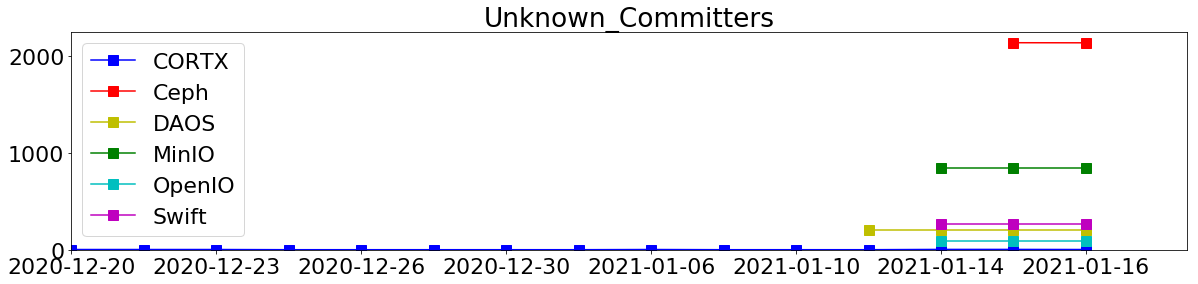

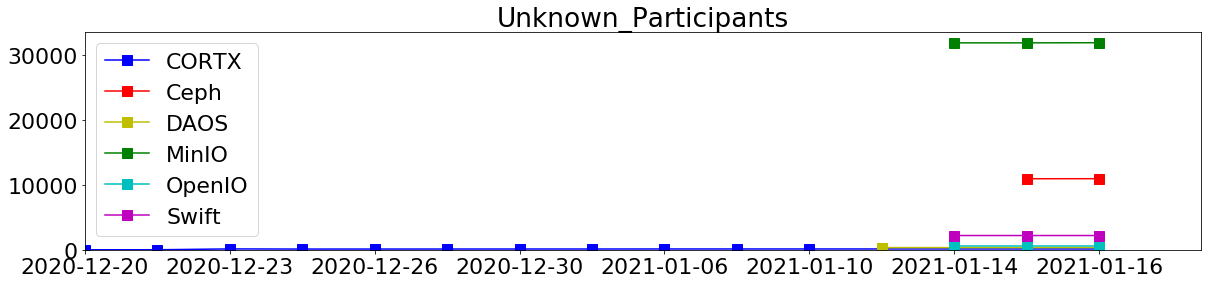

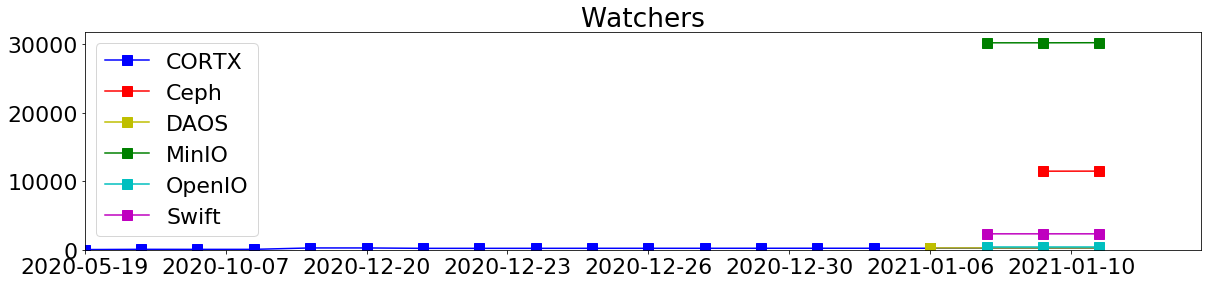

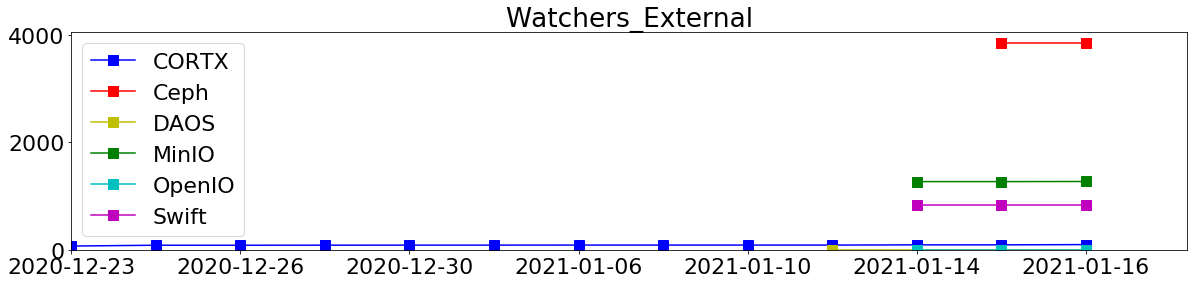

In [45]:
rname='GLOBAL'
def get_dataframe3(stats,key):
    data={}
    for org,values in stats.items():
        dates=[pd.to_datetime(k) for k in values.get_dates(rname)] # this might be better but isn't working...
        dates=values.get_dates(rname)
        values=values.get_values_as_numbers(rname,key)
        data[org]=(dates,values)
    df = get_dataframe2(data)
    df = df.dropna(how='all',axis=0) 
    return df

def org_to_project(org):
    for k,v in cc.projects.items():
        if v[0].lower() == org.lower():
            return k
    return org

# only need this temporarily since some of the projects only have one data point which won't show up with just lines
styles=['bs-', 'rs-', 'ys-','gs-','cs-','ms-','ks-',
        'bo-', 'ro-', 'yo-','go-','co-','mo-','ko-',
        'b^-', 'r^-', 'y^-','g^-','c^-','m^-','k^-',
]

stats={}
for org in cc.org_company_map.keys():
    project_name=org_to_project(org)
    stats[project_name]=cc.PersistentStats(org_name=org)
    if rname not in stats[project_name].get_repos():
        stats.pop(project_name) # haven't scraped for this org yet        
        
def make_graph2(stats,key):
    df=get_dataframe3(stats,key)
    ax=df.plot(title=key.title(),ylim=(0,None),style=styles)
    (min_x,max_x)=ax.get_xlim()
    max_x *= 1.1 # extend x-axis temporarily since some projects only currently have one datapoint
    plt.xlim(min_x,max_x)
    plt.legend(loc='upper left')
    plt.show()

def get_relevant_keys():
    all_keys=[]
    (dstats,dlatest)=stats['DAOS'].get_latest(rname)
    for k in dstats.keys():
        v = stats['DAOS'].get_values_as_numbers(rname,k)
        if v[-1] > 0:
            all_keys.append(k)
    return sorted(all_keys)

for k in get_relevant_keys():
    make_graph2(stats,k)